In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_path= '/content/drive/My Drive/'

Mounted at /content/drive


Load the libraries

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import os
tf.random.set_seed(42)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle

# Data Loading and preprocessing

Link dataset in tfrecords: https://drive.google.com/open?id=1sz5MURqR_S_-f4niCx3dYeMXAljowWRt

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 12)), types: (tf.float32, tf.int64)>
tf.Tensor([[0 0 0 0 0 0 0 0 1 0 1 0]], shape=(1, 12), dtype=int64)
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 12)), types: (tf.float32, tf.int64)>
tf.Tensor([[0 0 0 0 0 0 0 0 1 0 1 0]], shape=(1, 12), dtype=int64)
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 12)), types: (tf.float32, tf.int64)>
tf.Tensor([[0 0 0 0 1 0 0 0 0 0 0 0]], shape=(1, 12), dtype=int64)


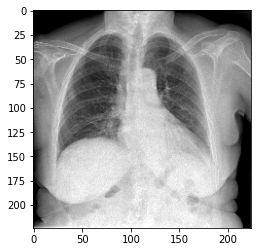

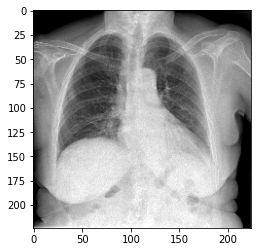

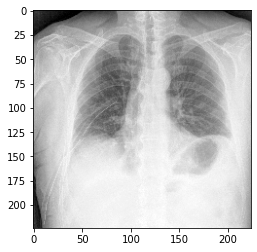

In [ ]:
### dataset con val e test (val per training di embeddings) quello originale 12
label_length=12

def record_parser(example):
    example_fmt = {'img': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label': tf.io.FixedLenFeature([label_length], tf.int64), 
        'path': tf.io.FixedLenFeature([], tf.string),
        "report": tf.io.FixedLenFeature([], tf.string)
    }
    parsed = tf.io.parse_single_example(example, example_fmt)
    
    #image = tf.io.decode_image(parsed["img"],channels=3)
    image=tf.cast(tf.reshape(tf.io.decode_raw(parsed["img"], tf.float32), shape=(224,224,3)), dtype=tf.float32)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image, parsed["label"], parsed["path"], parsed["report"]

def record_parser_img_label(example):
    example_fmt = {'img': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label': tf.io.FixedLenFeature([label_length], tf.int64), 
        'path': tf.io.FixedLenFeature([], tf.string),
        "report": tf.io.FixedLenFeature([], tf.string)
    }
    parsed = tf.io.parse_single_example(example, example_fmt)
    
    #image = tf.io.decode_image(parsed["img"],channels=3)
    image=tf.cast(tf.reshape(tf.io.decode_raw(parsed["img"], tf.float32), shape=(224,224,3)), dtype=tf.float32)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image, parsed["label"]

def load_tfexamples(full_path, batch_size=1):
    dataset = tf.data.TFRecordDataset(full_path)
    parsed_dataset = dataset.map(record_parser_img_label,num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(batch_size, drop_remainder=False).prefetch(1)
    print(parsed_dataset)
    for el in parsed_dataset:
        print(el[1])
        plt.figure()
        plt.imshow(el[0][0,:,:,0], cmap="gray")
        break
    return parsed_dataset
#test_dataset=load_tfexamples(full_path)
full_path = base_path+'X-RAY/TFrecords/TFrecord_file.tfrecords'
val_dataset_2=load_tfexamples(base_path+"X-RAY/TFrecords/TFrecord_file_val.tfrecords")
test_dataset_2=load_tfexamples(base_path+"X-RAY/TFrecords/TFrecord_file_test.tfrecords")


In [ ]:
unbatched_test = test_dataset.unbatch()
test_Y = []
for img, labels in unbatched_test:
  test_Y.append(labels.numpy())
test_Y = np.array(test_Y)
test_Y.shape

(941, 12)

In [ ]:
hum_labels = ["Medias", "Pleura", "Diaphgram", "Device", "Other", "GI", "PNX", 
             "Cardiac", "Lung", "Bone", "Vascular", "Normal"]
hum_labels_sel=[ "Pleura", "Device", "PNX", 
             "Cardiac", "Lung", "Bone", "Normal"]
mask_labels=[hum_labels[i] in hum_labels_sel for i, _ in enumerate(hum_labels)]
#for idx, el in enumerate(hum_labels):
  #if el not in hum_labels_sel:
  #  continue
  # print(el)
  # print(np.sum(test_Y[:,idx]))
  
  # print(np.sum(test_Y[:,idx])/test_Y.shape[0]*100)
  # print(test_Y.shape[0]-np.sum(test_Y[:,idx]))
  # print((1-(np.sum(test_Y[:,idx])/test_Y.shape[0]))*100)


SyntaxError: ignored

# Load Models

Link alla cartella contenente i modelli trainati: https://drive.google.com/open?id=1EkuS27OzYyQ4fqfiNQdcrO6nQkyKBJ9B

In [ ]:
from tensorflow.keras.models import load_model

model_path = base_path+'X-RAY/Models'
def load_models(model_path):
  models = []
  for model in os.listdir(model_path):
    print('loading model: {}'.format(model))
    #print(load_model(os.path.join(model_path,model)).summary)
    models.append(load_model(os.path.join(model_path,model)))
  return models

models = load_models(model_path)


loading model: densenet121_model.hdf5
loading model: densenet169_model.hdf5
loading model: vgg19_model.hdf5
loading model: xception_model.hdf5
loading model: densenet201_model.hdf5
loading model: vgg16_model.hdf5
loading model: inceptionresnetv2_model.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: keras_applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


# Model Predictions - Baseline model

In [ ]:
unbatched_test = test_dataset.unbatch()
test_Y = []
for img, labels in unbatched_test:
  test_Y.append(labels.numpy())
test_Y = np.array(test_Y)

In [ ]:
def make_predictions(models,test_dataset):
  predictions = []
  for model in models:
    predictions.append(model.predict(test_dataset))
  return np.mean(predictions,axis=0)

model_predictions = make_predictions(models,test_dataset_2)


**Mapping chexpert to Humcxr**

In [ ]:
def chexpert_to_hum(predictions, labels):
  corrispondence={"Pleura": predictions_pleura(predictions, labels), 
                  "Device": predictions_device(predictions, labels), 
                  "PNX": predictions_PNX(predictions, labels), 
                  "Cardiac": predictions_cardiac(predictions, labels), 
                  "Lung": predictions_lung(predictions, labels), 
                  "Bone": predictions_bone(predictions, labels), 
                  "Normal": predictions_normal(predictions, labels)
                  }
  return corrispondence
def predictions_pleura(predictions, labels):
  dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
  target=['Pleural Effusion', 'Pleural Other']
  mask=[dummy_labels[i] in target for i, _ in enumerate(dummy_labels)]
  prediction=np.max(predictions[:, mask], axis=1)
  return prediction, labels[:,1]

def predictions_lung(predictions, labels):
  dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
  target=['Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis']
  mask=[dummy_labels[i] in target for i, _ in enumerate(dummy_labels)]
  prediction=np.max(predictions[:,mask], axis=1)
  return prediction, labels[:,8]



def predictions_device(predictions, labels):
  dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
  target=['Support Devices']
  mask=[dummy_labels[i] in target for i, _ in enumerate(dummy_labels)]
  prediction=np.max(predictions[:,mask], axis=1)
  return prediction, labels[:,3]

def predictions_PNX(predictions, labels):
  dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
  target=['Pneumothorax']
  mask=[dummy_labels[i] in target for i, _ in enumerate(dummy_labels)]
  prediction=np.max(predictions[:,mask], axis=1)
  return prediction, labels[:,6]

def predictions_cardiac(predictions, labels):
  dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
  target=['Enlarged Cardiomediastinum', 'Cardiomegaly']
  mask=[dummy_labels[i] in target for i, _ in enumerate(dummy_labels)]
  prediction=np.max(predictions[:,mask], axis=1)
  return prediction, labels[:,7]

def predictions_bone(predictions, labels):
  dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
  target=['Fracture']
  mask=[dummy_labels[i] in target for i, _ in enumerate(dummy_labels)]
  prediction=np.max(predictions[:,mask], axis=1)
  return prediction, labels[:,9]

def predictions_normal(predictions, labels):
  dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
  target=['No Finding']
  mask=[dummy_labels[i] in target for i, _ in enumerate(dummy_labels)]
  prediction=np.max(predictions[:,mask], axis=1)
  return prediction, labels[:,-1]


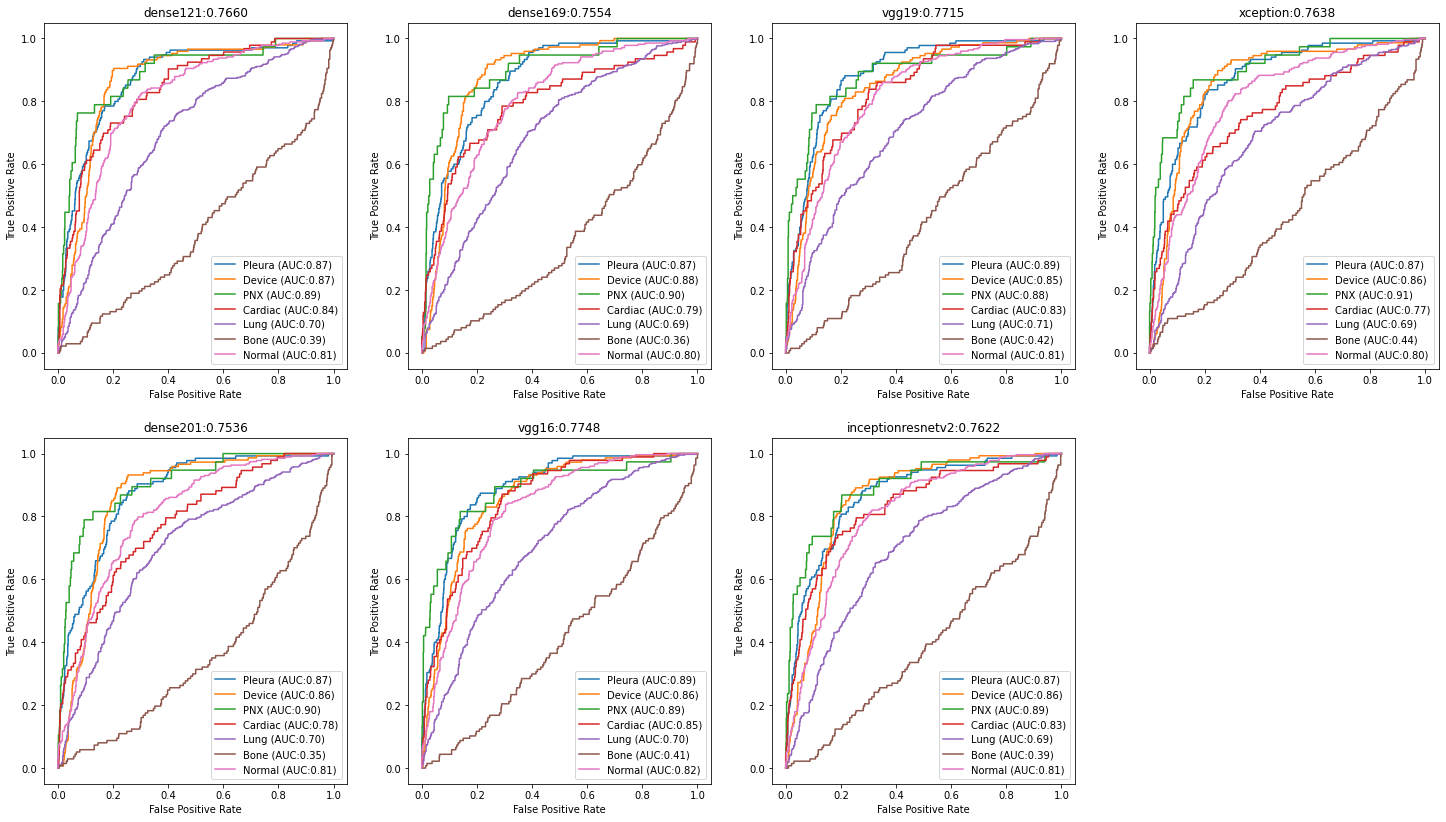

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
hum_labels=[ "Pleura", "Device", "PNX", "Cardiac", "Lung", "Bone", "Normal"]
titles=["dense121", "dense169", "vgg19", "xception", "dense201", "vgg16", "inceptionresnetv2"]
#fig, c_ax = plt.subplots(2,3, figsize = (15, 10))
fig = plt.figure(figsize=(25,14))


j = 1
for model in models:
  pred = model.predict(test_dataset)
  pred=chexpert_to_hum(pred, test_Y)
  aurocs= []
  ax = fig.add_subplot(2,4,j)
  for (i, label) in enumerate(hum_labels):
      fpr, tpr, thresholds = roc_curve(pred[label][1].astype(int), pred[label][0])
      #ax = fig.add_subplot(2,3,j)
      ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
      aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('{}:{:0.4f}'.format(titles[j-1],np.mean(aurocs)))
  j+=1 
plt.savefig(base_path+"/X-RAY/single_net_performance", dpi=300)

# Stacking

In [ ]:
def build_meta_learner_dataset(models,dataset):
  predictions = []
  for model in models: 
    predictions.append(model.predict(dataset))
  predictions = np.array(predictions)
  new_pred = []
  for i in range(predictions.shape[1]):
    new_pred.append(predictions[:,i])
  new_pred = np.array(new_pred)
  X = new_pred.reshape((new_pred.shape[0],-1))

  unbatched_dataset = dataset.unbatch()
  Y = []
  for _, labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y)
  return X , Y


from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
train_X, train_Y= build_meta_learner_dataset(models,val_dataset_2)
test_X, test_Y= build_meta_learner_dataset(models,test_dataset_2)

rf.fit(train_X,train_Y.astype('int'))
predictions = rf.predict_proba(test_X)
prob_pred = np.array(predictions)[:,:,1].T

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
hum_labels=["Pleura",  "Device", "PNX",  "Cardiac", "Lung", "Bone", "Normal"]

fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(hum_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), prob_pred[:,i])
    #ax = fig.add_subplot(2,3,j)
  ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
  aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))
plt.savefig(base_path+"/X-RAY/stacking")

# Embedding

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,RepeatedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def build_embedding_dataset(model,dataset):
  X = model.predict(dataset)
  
  unbatched_dataset = dataset.unbatch()
  Y = []
  for _,labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y).astype('int')  
  
  return X,Y

Uncomment if it is the first time that the embeddings are extracted

In [ ]:
##### to create and save embeddings

# def save_ensemble_embeddings (val_dataset, test_dataset, models):
#   models_name=["densenet121", "densenet169", "vgg19", "xception", "densenet201", "vgg16", "inceptionresnetv2"]
#   embeddings={}
#   for idx, model in enumerate(models):
#     print(model)
#     if (idx==3)|(idx==5): 
#       x=model.get_layer("global_average_pooling2d_2").output
#     elif (idx==6):
#       x=model.get_layer("global_average_pooling2d_1").output
#     else:
#       x=model.get_layer('global_average_pooling2d').output
#     #x = model.get_layer('global_average_pooling2d').output 
#     embedding_model = Model(inputs=model.input, outputs=x)
#     val_X, val_Y = build_embedding_dataset(embedding_model,val_dataset_2)
#     test_X, test_Y = build_embedding_dataset(embedding_model,test_dataset_2)
#     val_Y=val_Y[:,mask_labels]
#     test_Y=test_Y[:,mask_labels]
#     embeddings[models_name[idx]]=(val_X, val_Y, test_X, test_Y)
#   return embeddings
# hum_all = ["Medias", "Pleura", "Diaphgram", "Device", "Other", "GI", "PNX", 
#             "Cardiac", "Lung", "Bone", "Vascular", "Normal"]
# hum_targets=["Pleura",  "Device", "PNX",  "Cardiac", "Lung", "Bone", "Normal"]
# mask_labels=[hum_all[i] in hum_targets for i, _ in enumerate(hum_all)]
# mask_labels
# embeddings=save_ensemble_embeddings(val_dataset_2, test_dataset_2, models)

# with open (base_path+"X-RAY/Embeddings/embeddings.pkl", "wb") as f:
#   pickle.dump(embeddings, f)

CPU times: user 1min 15s, sys: 4.03 s, total: 1min 19s
Wall time: 1min 18s


In [ ]:
# embeddings already computed and saved
with open (base_path+"X-RAY/Embeddings/embeddings.pkl", "rb") as f:
  embeddings=pickle.load(f)

### training pre-defined RF model

In [ ]:
def train_rf_embeddings(embeddings):
    models_name=["densenet121", "densenet169", "vgg19", "xception", "densenet201", "vgg16", "inceptionresnetv2"]
    predictions=[]
    for model in models_name:
      val_X=embeddings[model][0]
      val_Y=embeddings[model][1]
      test_X=embeddings[model][2]
      test_Y=embeddings[model][3]
      rfc = RandomForestClassifier(n_jobs=-1,verbose = 0 ,
                            bootstrap= False,max_depth = 5,
                            max_features= 'sqrt',
                            min_samples_leaf= 1,min_samples_split= 2,n_estimators= 1000)
      rfc.fit(val_X,val_Y.astype(int))
      preds = rfc.predict_proba(test_X)
      preds = np.array(preds)[:,:,1].T
      predictions.append(preds)
    final_predictions = np.array(predictions)
    return final_predictions
final_predictions=train_rf_embeddings(embeddings)
#entropies = entropy([final_predictions,1-final_predictions],base = 2)
#final_predictions=np.average(final_predictions,axis=0,weights=1-entropies)
final_predictions=np.average(final_predictions,axis=0)
final_predictions.shape

CPU times: user 2min 24s, sys: 830 ms, total: 2min 25s
Wall time: 1min 15s


In [ ]:
hum_targets=["Pleura",  "Device", "PNX",  "Cardiac", "Lung", "Bone", "Normal"]
fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
#results=chexpert_to_hum(prob_pred, test_Y)
for (i, label) in enumerate(hum_targets):
  y_test=embeddings["vgg16"][3][:,i]
  preds=final_predictions[:,i]
  fpr, tpr, thresholds = roc_curve(y_test, preds)
    #ax = fig.add_subplot(2,3,j)
  ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
  aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))

plt.savefig(base_path+"X-RAY/ROC_embedded_ensembling_predictions.png", dpi=300)  

### Grid-search CV for tuning

In [ ]:
### ML models

random_seed=0
n_estimators=100
def finetune_cv(data, labels, param_grid, model):
  cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
  grid = GridSearchCV(model, param_grid, cv=cv, verbose=1, scoring="roc_auc", n_jobs=-1)
  grid.fit(data,labels)
  print("best estimator:")
  print(grid.best_estimator_)
  best_model = grid.best_estimator_
  return best_model
# Number of trees in random forest
param_grid_xrt = {'n_estimators': [10, 50, 100, 200],
                 'criterion': ["gini", "entropy"],
              'max_depth': [2,5,10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'random_state': [0], 
              'n_jobs':[-1]}
param_grid_rf = {'n_estimators': [10, 20, 100],
              'max_depth': [None, 2,3,5,10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False],
              'random_state': [0]}

param_grid_KNN = {'n_neighbors': [3,4,5,6,7,8,9,10], 
                  'p': [1,2], 
                  'n_jobs':[-1]}

ML_models = {'Decision Tree':DecisionTreeClassifier(max_depth=10,
														random_state=random_seed),
					'Random Forest':finetune_cv(embeddings["densenet201"][0],embeddings["densenet201"][1], param_grid_rf, RandomForestClassifier()),
					'Extremely Randomized Trees':finetune_cv(embeddings["densenet201"][0],embeddings["densenet201"][1], param_grid_xrt, ExtraTreesClassifier()),
					'KNN': finetune_cv(embeddings["densenet121"][0],embeddings["densenet121"][1], param_grid_KNN, KNeighborsClassifier())
				}


In [ ]:
### sono i modelli che erano risultati dalla gridsearch CV. usa questi

ML_models={'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=10, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=0, splitter='best'),
 'Extremely Randomized Trees': ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='entropy', max_depth=10, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False),
 'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=10, p=1,
                      weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=10, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=4, min_samples_split=10,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
                        warm_start=False)}

 'Random Forest': RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=10, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=4, min_samples_split=10,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False)

{'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=10, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=0, splitter='best'),
 'Extremely Randomized Trees': ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='entropy', max_depth=10, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False),
 'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=10, p=1,
                      weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=10, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=4, min_samples_split=10,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
                        warm_start=False)}

In [ ]:
def train_ML_embeddings(embeddings, ML_models):
    models_name=["densenet121", "densenet169", "vgg19", "xception", "densenet201", "vgg16", "inceptionresnetv2"]
    final_predictions={}
    for ml in ML_models:
      ml_predictor=ML_models[ml]
      print(ml)
      predictions=[]
      for model in models_name:
        val_X=embeddings[model][0]
        val_Y=embeddings[model][1]
        test_X=embeddings[model][2]
        test_Y=embeddings[model][3]
        ml_predictor.fit(val_X,val_Y.astype(int))
        preds = ml_predictor.predict_proba(test_X)
        preds = np.array(preds)[:,:,1].T
        predictions.append(preds) 
      entropies = entropy([np.array(predictions),1-np.array(predictions)],base = 2)
      final_predictions[ml]=np.average(np.array(predictions),axis=0,weights=1-entropies)

      ## if simple average uncomment and comment entropies
      #final_predictions[ml]=np.average(np.array(predictions),axis=0)
    return final_predictions

final_predictions=train_ML_embeddings(embeddings, ML_models)

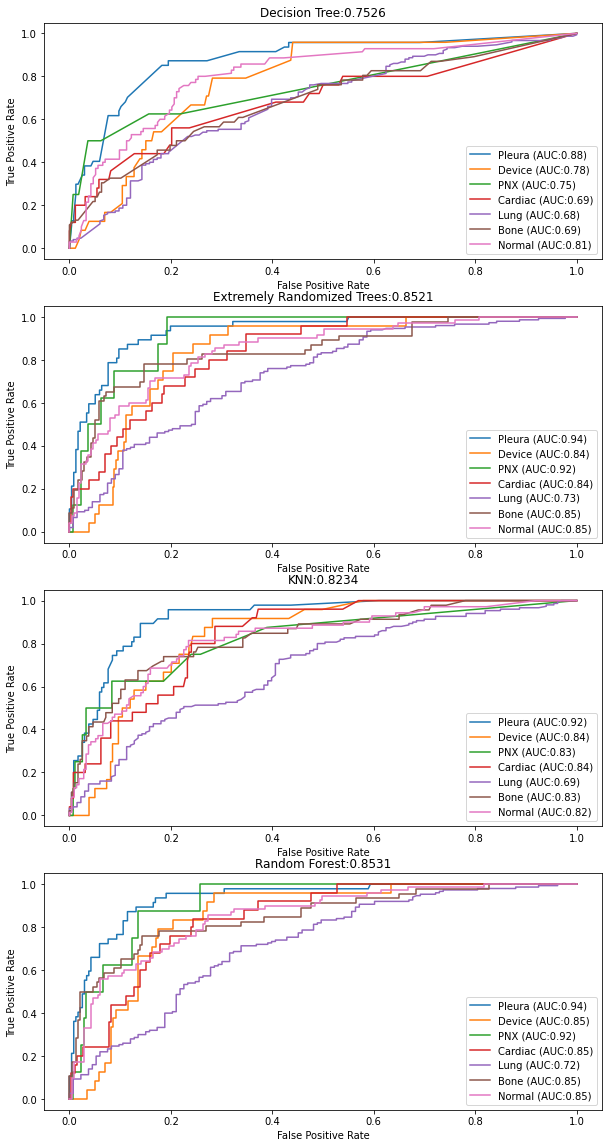

In [ ]:
hum_targets=["Pleura",  "Device", "PNX",  "Cardiac", "Lung", "Bone", "Normal"]
fig = plt.figure(figsize=(10,20))
for idx,ml in enumerate(ML_models):
  pred = final_predictions[ml]
  aurocs= []
  ax = fig.add_subplot(4,1,idx+1)
  for (i, label) in enumerate(hum_targets):
      y_test=embeddings["vgg16"][3][:,i]
      fpr, tpr, thresholds = roc_curve(y_test, pred[:,i])
      #ax = fig.add_subplot(2,3,j)
      ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
      aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('{}:{:0.4f}'.format(ml,np.mean(aurocs)))
plt.savefig(base_path+"/X-RAY/results/grid_search_results_entropy")

# embedding + stacking

In [ ]:
def train_ML_embeddings(embeddings, ML_models, meta_learner):
    models_name=["densenet121", "densenet169", "vgg19", "xception", "densenet201", "vgg16", "inceptionresnetv2"]
    final_predictions={}
    for ml in ML_models:
      ml_predictor=ML_models[ml]
      print(ml)
      predictions_test=[]
      predictions_val=[]
      for model in models_name:
        val_X=embeddings[model][0]
        val_Y=embeddings[model][1]
        test_X=embeddings[model][2]
        test_Y=embeddings[model][3]
        ml_predictor.fit(val_X,val_Y.astype(int))
        preds_val = ml_predictor.predict_proba(val_X)
        preds_val = np.array(preds_val)[:,:,1].T
        predictions_val.append(preds_val)
        preds_test = ml_predictor.predict_proba(test_X)
        preds_test = np.array(preds_test)[:,:,1].T
        predictions_test.append(preds_test) 
      val_X_stack=stack_preds(np.array(predictions_val))
      print(val_X_stack.shape)
      print(val_Y.shape)
      test_X_stack=stack_preds(np.array(predictions_test))
      print(test_X_stack.shape)
      print(test_Y.shape)
      meta_learner.fit(val_X_stack,val_Y.astype('int'))
      predictions = meta_learner.predict_proba(test_X_stack)
      print(np.array(predictions).shape)
      prob_pred = np.array(predictions)[:,:,1].T
      final_predictions[ml]=prob_pred
    return final_predictions

def stack_preds(predictions):
  new_pred = []
  for i in range(predictions.shape[1]):
    new_pred.append(predictions[:,i])
  new_pred = np.array(new_pred)
  X = new_pred.reshape((new_pred.shape[0],-1))
  return X


In [ ]:
rf=RandomForestClassifier()
final_predictions=train_ML_embeddings(embeddings, ML_models, meta_learner=rf)



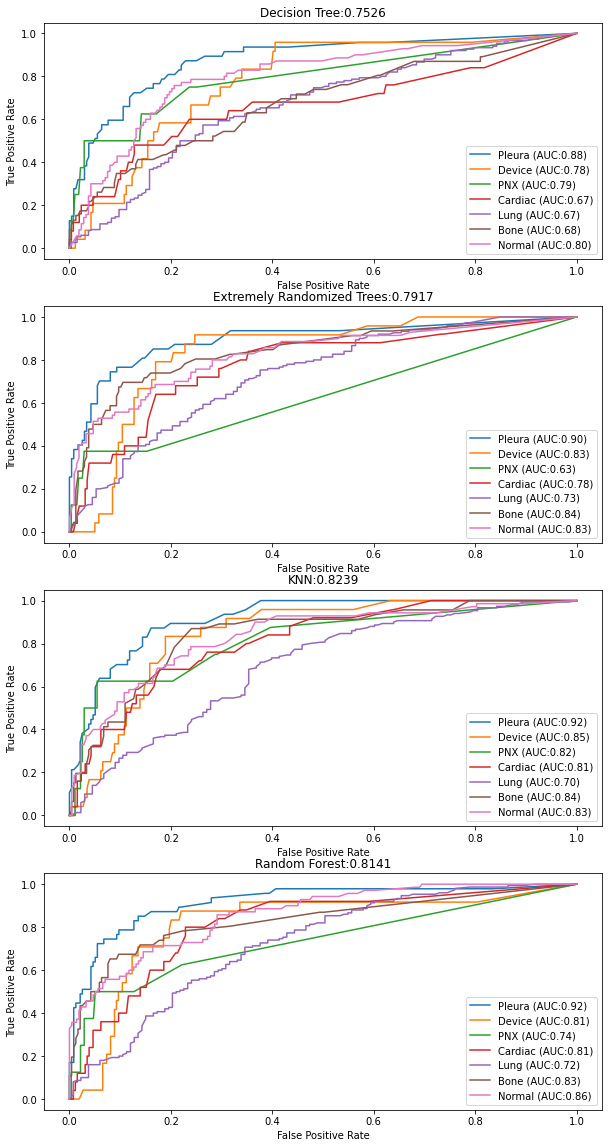

In [ ]:
hum_targets=["Pleura",  "Device", "PNX",  "Cardiac", "Lung", "Bone", "Normal"]
fig = plt.figure(figsize=(10,20))
for idx,ml in enumerate(ML_models):
  pred = final_predictions[ml]
  aurocs= []
  ax = fig.add_subplot(4,1,idx+1)
  for (i, label) in enumerate(hum_targets):
      y_test=embeddings["vgg16"][3][:,i]
      fpr, tpr, thresholds = roc_curve(y_test, pred[:,i])
      #ax = fig.add_subplot(2,3,j)
      ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
      aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('{}:{:0.4f}'.format(ml,np.mean(aurocs)))
plt.savefig(base_path+"/X-RAY/results/grid_search_results_stacking")